# What factors affect energy consumption at the event center?
## And, how can we optimize energy usage and cost efficiency?

*To ensure the privacy and confidentiality of the client I work with, all data wrangling and initial exploration activities included the renaming of features and the obfuscation of values related to the actual event space.*

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_renamed = pd.read_csv('renamed_data.csv')

data_renamed['Event_Start'].fillna(data_renamed['Date'], inplace=True)
data_renamed['Event_End'].fillna(data_renamed['Date'], inplace=True)

# Convert date columns to datetime format
data_renamed['Event_End'] = pd.to_datetime(data_renamed['Event_End'])
data_renamed['Event_Start'] = pd.to_datetime(data_renamed['Event_Start'])
data_renamed['Date'] = pd.to_datetime(data_renamed['Date'])

# Define a function to classify dates into seasons
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

# Apply the function to create a new 'Season' column
data_renamed['Season'] = data_renamed['Date'].apply(get_season)

data_renamed.head()

,Date,Usage,Temperature,Event_Start,Event_End,Attendance,Total_sq_ft,Hall_A,Meeting_Room_A,Main_Room,Hall_B,Meeting_Room_B,Hall_C,Meeting_Room_C,Hall_D,Meeting_Room_D,Terrace,Parking,Season
0,2018-01-05,137305.008,55.062500,2018-01-05,2018-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,Winter
1,2018-01-06,152705.016,56.250000,2018-01-06,2018-01-06,0,0,0,0,0,0,0,0,0,0,0,0,0,Winter
2,2018-01-07,179891.784,55.229167,2018-01-07,2018-01-07,0,0,0,0,0,0,0,0,0,0,0,0,0,Winter
3,2018-01-08,211425.840,52.208333,2018-01-08,2018-01-08,0,0,0,0,0,0,0,0,0,0,0,0,0,Winter
4,2018-01-09,284379.120,48.739583,2018-01-09,2018-01-12,175000,2184344,1,1,1,1,1,1,1,0,0,0,1,Winter


---

## Story Arc 1: The Impact of Temperature on Energy Usage

The focus is on exploring the link between **temperature** and **energy consumption**.

This entails the examination of energy usage trends, variations in consumption in relation to temperature fluctuations, and the identification of occasions when elevated temperatures coincide with peak energy demand. The goal is to shed light on how external temperatures impact energy utilization, such as the potential increase in consumption during hotter weather, often driven by higher air conditioning usage.

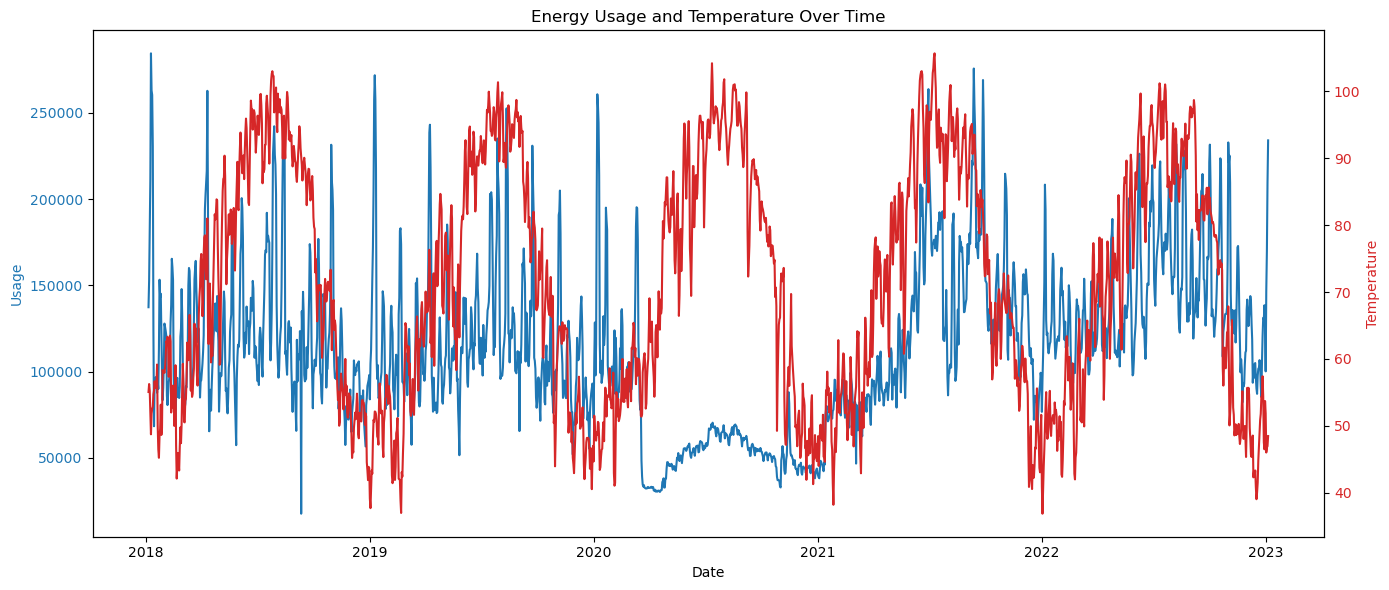

In [3]:
# Set up the figure and axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plotting energy usage
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Usage', color=color)
ax1.plot(data_renamed['Date'], data_renamed['Usage'], color=color, label='Usage')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis to plot temperature
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Temperature', color=color)  
ax2.plot(data_renamed['Date'], data_renamed['Temperature'], color=color, label='Temperature')
ax2.tick_params(axis='y', labelcolor=color)

# Set the x-axis ticks to be yearly
ax1.xaxis.set_major_locator(mdates.YearLocator())

# Format the x-axis dates as years
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Title and layout adjustment
plt.title('Energy Usage and Temperature Over Time')
fig.tight_layout()  

# Show the plot
plt.show()

Observations reveal clear seasonal patterns in both energy usage and temperature, marked by distinct peaks and troughs. A positive correlation between temperature and energy consumption is evident, as they tend to increase and decrease together, although occasional misalignments occur. Notably, sporadic spikes in energy usage are observed, potentially attributed to large-scale events or other factors independent of temperature.

In [4]:
# Calculating the correlation between temperature and energy usage
correlation_temp_usage = data_renamed['Temperature'].corr(data_renamed['Usage'])
correlation_temp_usage

0.30192853761178523

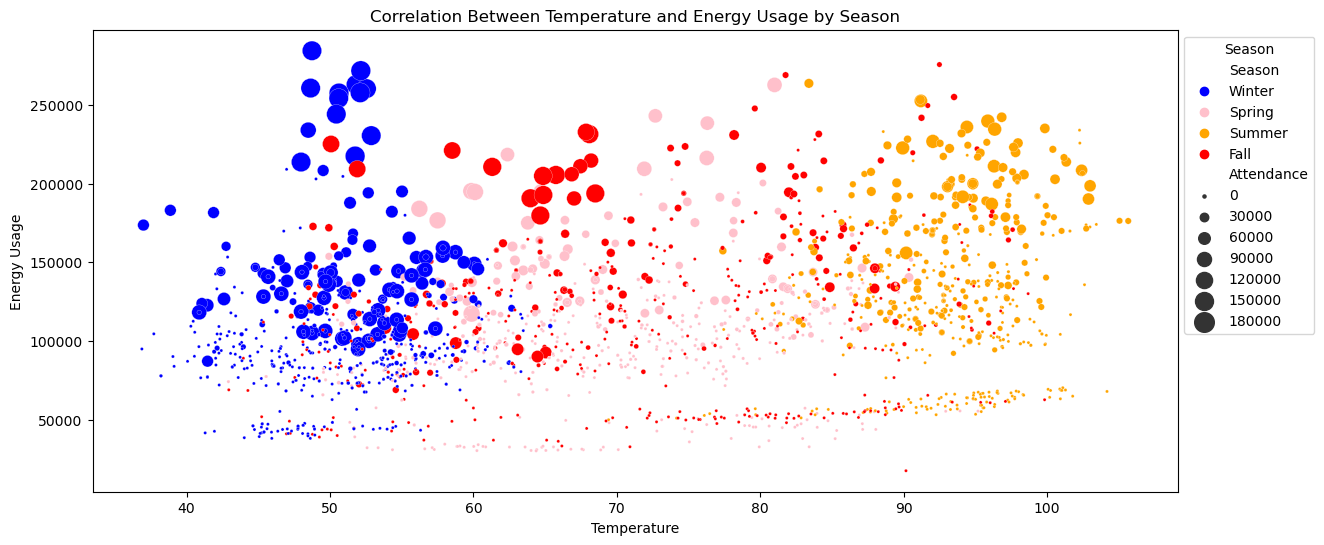

In [5]:
# Set up the custom color palette for each season
custom_palette = {'Winter': 'blue', 'Spring': 'pink', 'Summer': 'orange', 'Fall': 'red'}

# Set up the figure
plt.figure(figsize=(14, 6))

# Create a scatter plot and fit a regression line, colored by season using the custom palette
# Size is based on the 'Attendance' column
sns.scatterplot(x='Temperature', y='Usage', data=data_renamed, hue='Season', palette=custom_palette, size='Attendance', sizes=(5, 200))

# Title and labels
plt.title('Correlation Between Temperature and Energy Usage by Season')
plt.xlabel('Temperature')
plt.ylabel('Energy Usage')

# Add a legend outside the plot
plt.legend(title='Season', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

In the data, a positive correlation is observed between temperature and energy usage, indicating a moderately strong connection where one tends to rise with the other. The red line visually confirms this upward trend, with data points spread out, signifying a complex relationship that's not strictly linear. Some outliers hint at exceptional events affecting energy consumption beyond temperature alone. These findings suggest that temperature influences energy usage but isn't the sole factor; events, space usage, and attendance also play significant roles. 

Despite a general trend of higher temperatures leading to increased energy usage, the relationship is flexible, influenced by various factors beyond temperature, emphasizing the need to explore these elements for a comprehensive understanding of energy dynamics. This is especially pertinent considering the **consistent high energy demand across all seasons, where higher attendance appears to be a key driver**.

---

## Story Arc 2: The Energy Footprint of Events

The focus shifts towards exploring the energy dynamics of events, with a particular emphasis on understanding the impact of **event size (attendance)** on energy usage. 

Key questions addressed include variations in energy consumption between event and non-event days, the relationship between attendee numbers and energy usage, and whether larger events demonstrate significantly higher energy intensity per attendee in contrast to smaller gatherings.

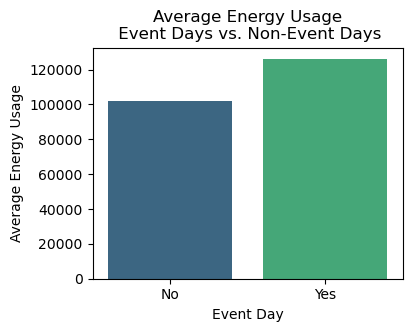

In [6]:
# Making adjustments for NaN values
data_adjusted = data_renamed.copy()
data_adjusted['Event_Start'] = data_adjusted['Event_Start'].fillna(data_adjusted['Date'])
data_adjusted['Event_End'] = data_adjusted['Event_End'].fillna(data_adjusted['Date'])
data_adjusted['Attendance'] = data_adjusted['Attendance'].fillna(0)

# Determine whether each day is an event day or a non-event day based on adjusted data
data_adjusted['Event_Day'] = data_adjusted['Attendance'] > 0

# Calculate the average energy usage on event days vs. non-event days with adjusted data
average_usage_event_vs_nonevent_adjusted = data_adjusted.groupby('Event_Day')['Usage'].mean()

# Visualizing the average energy usage on event days vs. non-event days with adjusted data
plt.figure(figsize=(4, 3))
sns.barplot(x=average_usage_event_vs_nonevent_adjusted.index, y=average_usage_event_vs_nonevent_adjusted.values, palette='viridis')

# Title and labels
plt.title('Average Energy Usage\n Event Days vs. Non-Event Days')
plt.xlabel('Event Day')
plt.ylabel('Average Energy Usage')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# Show the plot
plt.show()

Observations show that, on event days, the average energy usage is approximately 126,241 kWh, while on non-event days, it averages around 102,251 kWh. 

These findings highlight a **substantial increase in energy consumption during events compared to non-event days**, emphasizing the significant impact of events on the event center's energy demands.

In [7]:
# Calculating the correlation between attendance and energy usage
correlation_attendance_usage = data_adjusted['Attendance'].corr(data_adjusted['Usage'])
correlation_attendance_usage

0.44121987258359263

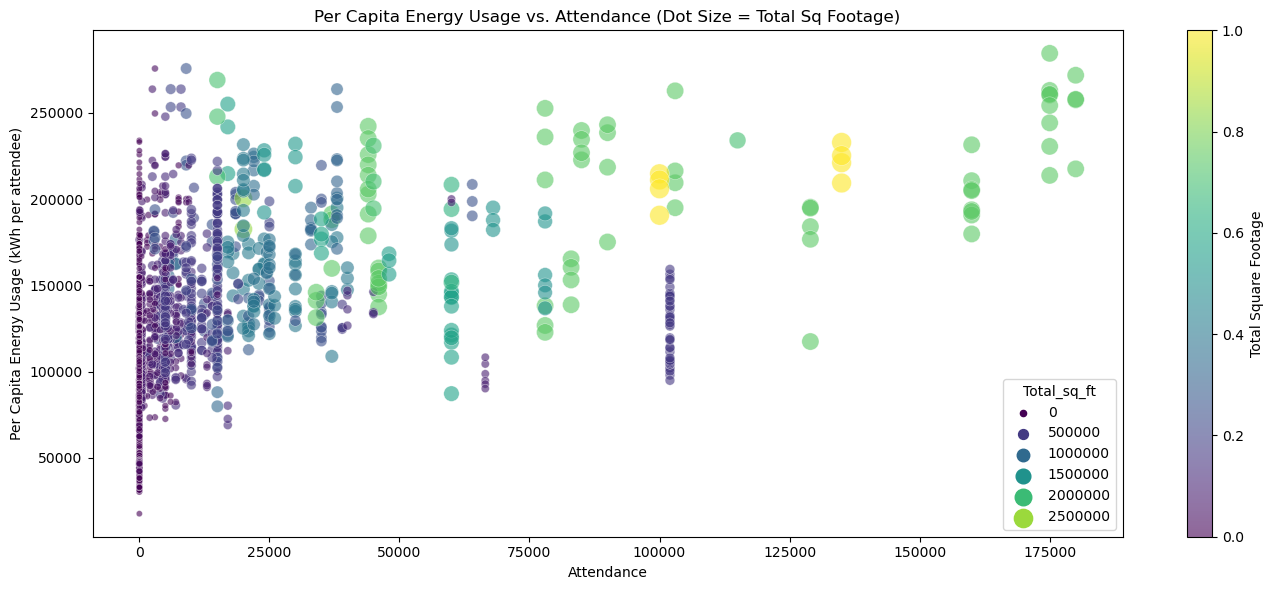

In [8]:
# Set up the figure
plt.figure(figsize=(14, 6))

# Create a scatter plot with dot size representing the square footage used
scatter = sns.scatterplot(x='Attendance', y='Usage', size='Total_sq_ft',
                sizes=(20, 200), alpha=0.6, data=data_adjusted, hue='Total_sq_ft', palette='viridis')

# Title and labels
plt.title('Per Capita Energy Usage vs. Attendance (Dot Size = Total Sq Footage)')
plt.xlabel('Attendance')
plt.ylabel('Per Capita Energy Usage (kWh per attendee)')

# Create a colorbar using the scatter object
colorbar = plt.colorbar(scatter.collections[0], label='Total Square Footage', orientation='vertical')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

Observations reveal a discernible positive relationship between attendance and energy usage, with an associated moderate correlation of 0.441 indicating a positive linear connection between the two variables. 

**Despite this trend, substantial variability exists**, suggesting that factors beyond attendance play a significant role in influencing energy consumption. Notably, per capita energy usage spans a wide range, from 0.91 kWh per attendee to 20,613.50 kWh per attendee, with **smaller events, particularly those utilizing extensive square footage, demonstrating notably high per capita energy usage**, while larger events, especially those with substantial space utilization, tend to exhibit lower per capita energy consumption. 

**This variability across event sizes and space utilization underscores opportunities for optimizing energy efficiency**. The higher per capita energy usage in smaller events may be influenced by fixed energy costs that do not scale linearly with attendance, highlighting the potential for energy-saving strategies through improved space utilization and operational factors.

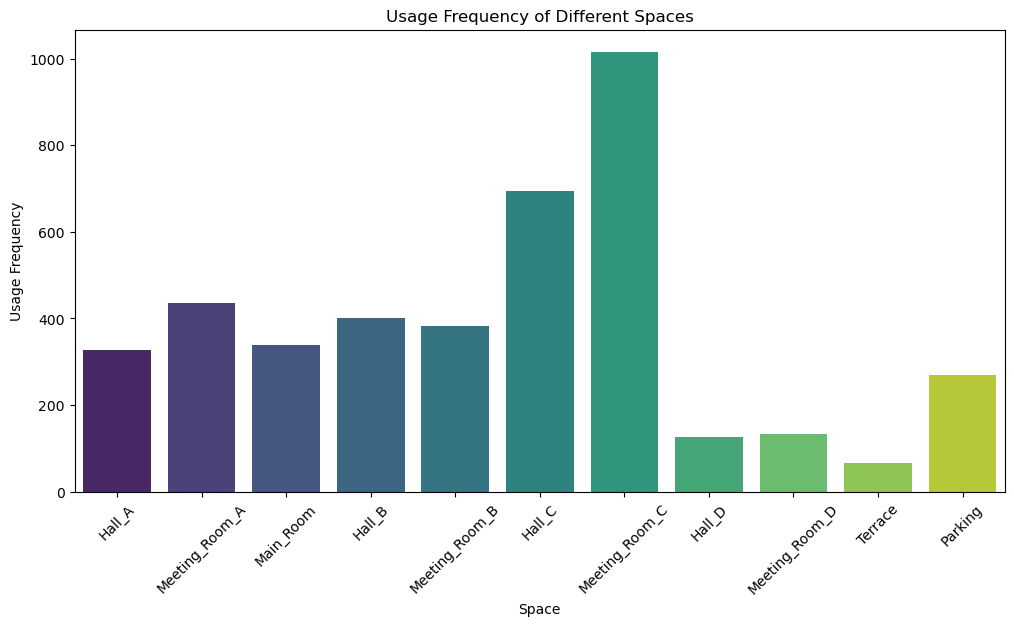

Meeting_Room_C    1016
Hall_C             695
Meeting_Room_A     435
Hall_B             401
Meeting_Room_B     383
Main_Room          339
Hall_A             327
Parking            269
Meeting_Room_D     134
Hall_D             127
Terrace             65
dtype: int64

In [9]:
# Extracting the usage of different spaces
space_usage = data_adjusted.loc[:, 'Hall_A':'Parking'].sum()

# Visualizing the usage of different spaces
plt.figure(figsize=(12, 6))
sns.barplot(x=space_usage.index, y=space_usage.values, palette='viridis')

# Title and labels
plt.title('Usage Frequency of Different Spaces')
plt.xlabel('Space')
plt.ylabel('Usage Frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Displaying the usage counts for reference
space_usage.sort_values(ascending=False)

Observations indicate variations in space usage, with Meeting Room C utilized 1,016 times and Hall C used 695 times, signifying high-frequency spaces. Meeting Room A, Hall B, Meeting Room B, Diamond Room, and Hall A fall within the moderate usage range, ranging from 300 to 500 times. In contrast, Meeting Room D, Hall D, and West Terrace show lower utilization, each with less than 200 instances. The parking area has been used 269 times. 

Insights suggest potential **over and underutilization of spaces**, emphasizing the need to diversify space usage, particularly in underutilized areas, to enhance energy efficiency and operational effectiveness.

---

## Story Arc 3: Length of events


The analysis revolves around understanding the relationship between **event duration and energy usage**, specifically to determine if longer events consistently result in higher energy consumption. 

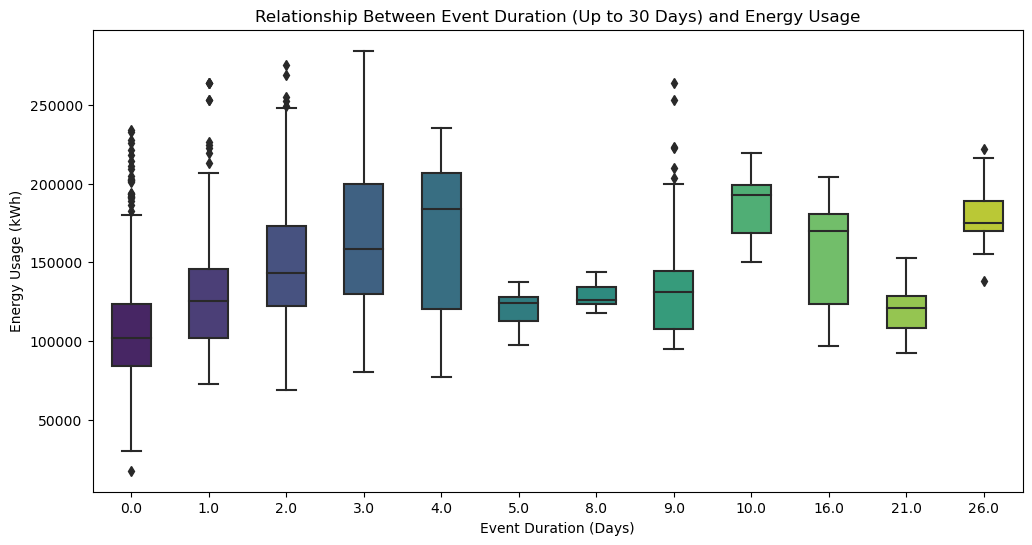

(None, 0.26956522768815405)

In [10]:
# Filter events with a duration of 30 days or less
data_adjusted['Event_Duration'] = (data_adjusted['Event_End'] - data_adjusted['Event_Start']).dt.total_seconds() / (3600 * 24)
filtered_data = data_adjusted[data_adjusted['Event_Duration'] <= 30] #adjusting for NaNs

# Calculating correlation between event duration and energy usage for the filtered data
correlation_duration_usage = filtered_data['Event_Duration'].corr(filtered_data['Usage'])

# Visualizing the relationship between event duration and energy usage using a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Event_Duration', y='Usage', data=filtered_data, width=0.5, palette='viridis')
plt.title('Relationship Between Event Duration (Up to 30 Days) and Energy Usage')
plt.xlabel('Event Duration (Days)')
plt.ylabel('Energy Usage (kWh)')


# Displaying the plot and correlation
plt.show(), correlation_duration_usage

The data shows Short-Duration, High-Usage Events: Some events, despite being of shorter duration, exhibit high energy usage. Also, the data suggests that longer events may utilize energy more efficiently over the duration of the event. Also, certain short-duration events may have high energy intensity, potentially due to specific requirements or setups.

## Story Arc 4: Multivariate Insights

The analysis explores how **temperature, attendance, and space usage collectively influence energy consumption**. Through multivariate analysis, this storyline provides insights into the interplay of these factors on energy consumption.

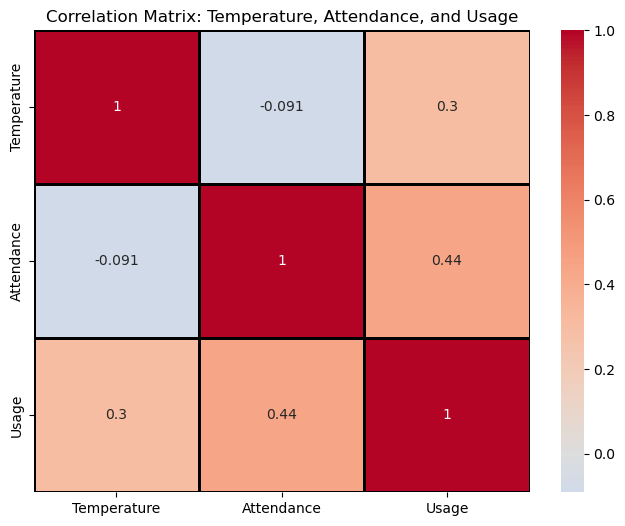

(None,
 Meeting_Room_A    0.393553
 Main_Room         0.391427
 Hall_A            0.384958
 Hall_C            0.383014
 Parking           0.338689
 Meeting_Room_D    0.311643
 Hall_D            0.309731
 Hall_B            0.257121
 Meeting_Room_B    0.246769
 Terrace           0.210767
 Meeting_Room_C    0.058242
 dtype: float64)

In [11]:
# Calculating correlation between Temperature, Attendance, and Usage
correlation_matrix = data_adjusted[['Temperature', 'Attendance', 'Usage']].corr()

# Visualizing the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=1, linecolor='black')
plt.title('Correlation Matrix: Temperature, Attendance, and Usage')

# Calculating correlation between space usage and energy usage
space_usage_correlation = data_adjusted.loc[:, 'Hall_A':'Parking'].apply(lambda x: np.corrcoef(data_adjusted['Usage'], x)[0, 1])

# Displaying the correlation matrix and space usage correlation
plt.show(), space_usage_correlation.sort_values(ascending=False)

The exploration into the linear relationships between energy usage and various factors shows a positive, moderate correlation between electricity usage and temperature, suggesting a co-varying upward trend. Conversely, a negative, weak, correlation is observed between temperature and attendance, indicating a subtle inverse relationship. A prominent, moderate correlation between attendance and energy usage highlights a significant association. 

When evaluating the correlations of different spaces, a spectrum from very weak to moderate positive correlation emerges between the utilization of various rooms and energy consumption, insinuating that individual spaces may not significantly steer overall energy use. 

**Overall, attendance conspicuously casts a more potent influence on energy usage compared to temperature. Also, different spaces exhibit varied correlations with energy usage, suggesting unique energy dynamics in each space.**

## Model to forecast energy usage using temperature, attendance, and square footage as predictors.

In [12]:
# Defining the features and target
features = data_renamed[['Temperature', 'Attendance', 'Total_sq_ft']]
target = data_renamed['Usage']

# Split your data into training and testing sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(features, target, test_size=0.2, random_state=42)

# Developing the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_new, y_train_new)

# Predicting energy usage using the testing set
rf_predictions = rf_model.predict(X_test_new)

# Evaluating the model
rf_mse = mean_squared_error(y_test_new, rf_predictions)
rf_mae = mean_absolute_error(y_test_new, rf_predictions)
rf_r2 = r2_score(y_test_new, rf_predictions)

# Displaying the evaluation metrics
rf_evaluation_metrics = {'Mean Squared Error': rf_mse, 'Mean Absolute Error': rf_mae, 'R-squared': rf_r2}
rf_evaluation_metrics

{'Mean Squared Error': 1004965608.3360428,
 'Mean Absolute Error': 23168.52760019828,
 'R-squared': 0.5347731909485951}

The **Random Forest model**, which employs Temperature, Attendance, and Total Square Footage as predictors, demonstrates sensitivity to outliers, indicating that larger errors are significantly pronounced. The model accounts for approximately 53.5% of the variability in energy usage, based on the features provided. Subsequently, hyperparameter tuning was utilized to enhance the model's performance.

In [13]:

# Defining the hyperparameter grid
param_distributions = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'max_features': [1.0, 'sqrt'] 
}

# Initializing the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Setting up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, 
                                   param_distributions=param_distributions,
                                   n_iter=100,  
                                   cv=3, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, 
                                   n_jobs=-1,
                                   random_state=42)

# Fitting the model
random_search.fit(X_train_new, y_train_new)

# Retrieving the best parameters and model
best_params = random_search.best_params_
best_rf_model = random_search.best_estimator_

# Predicting energy usage using the best model on test data
best_rf_predictions = best_rf_model.predict(X_test_new)

# Evaluating the best model
best_rf_mse = mean_squared_error(y_test_new, best_rf_predictions)
best_rf_mae = mean_absolute_error(y_test_new, best_rf_predictions)
best_rf_r2 = r2_score(y_test_new, best_rf_predictions)

# Displaying the best parameters and evaluation metrics
print("Best Parameters:", best_params)
print("Evaluation Metrics:")
print('Mean Squared Error:', best_rf_mse)
print('Mean Absolute Error:', best_rf_mae)
print('R-squared:', best_rf_r2)

# Feature Importance
feature_importances = best_rf_model.feature_importances_


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Evaluation Metrics:
Mean Squared Error: 786455934.5924488
Mean Absolute Error: 21151.705877251825
R-squared: 0.6359274567457223


The hyperparameters for the Random Forest model minimized the mean squared error during cross-validation on the training data. Now, The model explains 63.6% of the variability in energy usage, which indicates a fairly good fit.

Feature Importances:
* Temperature: 28.1%
* Attendance: 35.3%
* Total_sq_ft: 36.6%
    
**In this model, all features have substantial importance, with the total square foot area being slightly the most important.**